# Subsetting and retrieval of global sealevel/ssh observation data
If you prefer to interact with a Python script instead, you can convert this notebook to *.py with `jupyter nbconvert --to script subset_retrieve_sealevel_observations.ipynb`.


In [1]:
import os
import glob
import matplotlib.pyplot as plt
import xarray as xr
import dfm_tools as dfmt


To get an overview of the largest publicly available global sealevel observation datasets, we use `dfmt.ssh_catalog_subset()` with the `source` argument. For IOC and GESLA3 we also subset to highlight where they add significantly to the global spatial spatial coverage.

In [2]:
# ssc_catalog_gpd = dfmt.ssh_catalog_subset(source='ssc') # no data, only station locations
gesla_catalog_gpd = dfmt.ssh_catalog_subset(source='gesla3') # requires p-drive connection or download yourself
ioc_catalog_gpd = dfmt.ssh_catalog_subset(source='ioc')
cmems_list_gpd = dfmt.ssh_catalog_subset(source='cmems')
uhslc_json_rqds = dfmt.ssh_catalog_subset(source='uhslc-rqds')
uhslc_json_fast = dfmt.ssh_catalog_subset(source='uhslc-fast')
psmsl_gnssir_gpd = dfmt.ssh_catalog_subset(source='psmsl-gnssir')
rwsddl_gpd = dfmt.ssh_catalog_subset(source='rwsddl')
gtsm_era5_gpd = dfmt.ssh_catalog_subset(source='gtsm3-era5-cds')

# subsetting gesla
bool_ndays = gesla_catalog_gpd["time_ndays"] > 365
bool_country = gesla_catalog_gpd['country'].isin(['CAN','GRL'])
bool_contrib = gesla_catalog_gpd['contributor_abbreviated'].isin(['MEDS',"GLOSS"])
gesla_catalog_gpd_sel = gesla_catalog_gpd.loc[bool_country & bool_contrib & bool_ndays]

# subsetting ioc
bool_ndays = ioc_catalog_gpd["time_ndays"] > 365
bool_country = ioc_catalog_gpd['country'].isin(['RUS','IND']) #,'TUR','ISR','CYP','KRS','HRV','HEL'])
ioc_catalog_gpd_sel = ioc_catalog_gpd.loc[bool_ndays & bool_country]

# subsetting gtsm-era5 - exclude grid points in the open water 
gtsm_era5_gpd_sel = gtsm_era5_gpd.loc[~gtsm_era5_gpd['station_name_unique'].str.contains(r'grid', na=False)]


INFO - 2025-03-17T16:13:28Z - Checking if credentials are valid.
INFO - 2025-03-17T16:13:29Z - Valid credentials from configuration file.


>> reading coastlines: 0.92 sec
>> reading country borders: 0.01 sec


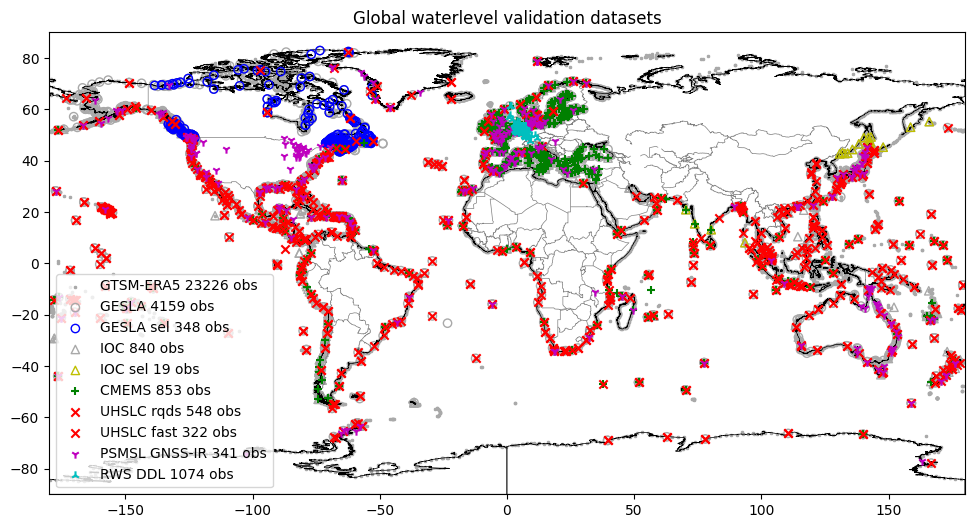

In [3]:
# plot stations
fig,ax = plt.subplots(figsize=(14,6))
gtsm_era5_gpd_sel.geometry.plot(ax=ax,marker="x", color="darkgray", markersize=3, label=f'GTSM-ERA5 {len(gtsm_era5_gpd_sel)} obs', zorder=-1)
gesla_catalog_gpd.geometry.plot(ax=ax, marker="o", color="darkgray", facecolor="none", label=f"GESLA {len(gesla_catalog_gpd)} obs")
gesla_catalog_gpd_sel.geometry.plot(ax=ax, marker="o", color="b", facecolor="none", label=f"GESLA sel {len(gesla_catalog_gpd_sel)} obs")
ioc_catalog_gpd.geometry.plot(ax=ax, marker="^", color="darkgray", facecolor="none", label=f"IOC {len(ioc_catalog_gpd)} obs")
ioc_catalog_gpd_sel.geometry.plot(ax=ax, marker="^", color="y", facecolor="none", label=f"IOC sel {len(ioc_catalog_gpd_sel)} obs")
cmems_list_gpd.geometry.plot(ax=ax, marker="+", color="g", label=f"CMEMS {len(cmems_list_gpd)} obs")
uhslc_json_rqds.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSLC rqds {len(uhslc_json_rqds)} obs")
uhslc_json_fast.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSLC fast {len(uhslc_json_fast)} obs")
psmsl_gnssir_gpd.geometry.plot(ax=ax, marker="1", color="m", label=f"PSMSL GNSS-IR {len(psmsl_gnssir_gpd)} obs")
rwsddl_gpd.geometry.plot(ax=ax, marker="2", color="c", label=f"RWS DDL {len(rwsddl_gpd)} obs")

ax.set_xlim(-181,181)
ax.set_ylim(-90,90)
ax.legend(loc=3)
ax.set_title("Global waterlevel validation datasets")
ax.set_xlim(-180,180)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)


Next, we will subset all sources in time and space by providing more arguments to `dfmt.ssh_catalog_subset`. The stations with data in this period and area are plotted. 

INFO - 2025-03-17T16:13:58Z - Checking if credentials are valid.
INFO - 2025-03-17T16:13:59Z - Valid credentials from configuration file.


retrieving psmsl-gnssir time extents for 12 stations: 1 2 3 4 5 6 7 8 9 10 11 12 
>> reading coastlines: 0.56 sec
>> reading country borders: 0.00 sec


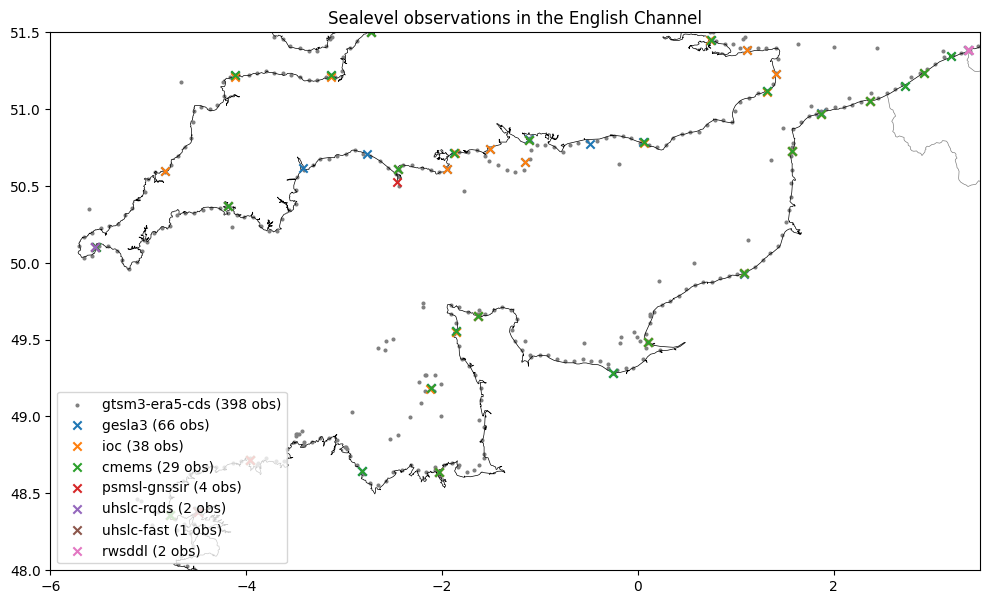

In [4]:
dir_output = "./sealevel_data_subset"
os.makedirs(dir_output, exist_ok=True)

lon_min, lon_max, lat_min, lat_max = -6, 3.5, 48, 51.5 # france
# lon_min, lon_max, lat_min, lat_max = 123, 148, 23, 47 # japan
# lon_min, lon_max, lat_min, lat_max = -20, 40, 25, 72 # europe
time_min, time_max = '2016-01-01','2016-02-01'

subset_kwargs = dict(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, 
                     time_min=time_min, time_max=time_max)
gesla_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gesla3', **subset_kwargs)
ioc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='ioc', **subset_kwargs)
cmems_list_gpd_sel = dfmt.ssh_catalog_subset(source='cmems', **subset_kwargs)
uhslc_json_rqds_sel = dfmt.ssh_catalog_subset(source='uhslc-rqds', **subset_kwargs)
uhslc_json_fast_sel = dfmt.ssh_catalog_subset(source='uhslc-fast', **subset_kwargs)
psmsl_gnssir_gpd_sel = dfmt.ssh_catalog_subset(source='psmsl-gnssir', **subset_kwargs)

# TODO: no time subsetting supported for rwsddl and gtsm-era5-cds
for key in ["time_min", "time_max"]:
    subset_kwargs.pop(key)
rwsddl_gpd_sel = dfmt.ssh_catalog_subset(source='rwsddl', **subset_kwargs)
gtsm_era5_gpd_sel = dfmt.ssh_catalog_subset(source='gtsm3-era5-cds', **subset_kwargs)
gtsm_era5_gpd_sel = gtsm_era5_gpd_sel.loc[~gtsm_era5_gpd_sel['station_name_unique'].str.contains(r'grid')] # exclude gridded points in open water
subset_gpd_list = [gtsm_era5_gpd_sel, gesla_catalog_gpd_sel,
                  ioc_catalog_gpd_sel, cmems_list_gpd_sel,
                  psmsl_gnssir_gpd_sel, uhslc_json_rqds_sel,
                  uhslc_json_fast_sel, rwsddl_gpd_sel]

# plot stations
fig,ax = plt.subplots(figsize=(12,7))
for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    if source == 'gtsm3-era5-cds':
        subset_gpd.geometry.plot(ax=ax, marker=".", color="grey", markersize=15, label=f"{source} ({nstations} obs)", zorder=-1)
    else:
        subset_gpd.geometry.plot(ax=ax, marker="x", label=f"{source} ({nstations} obs)")
ax.legend(loc=3)
ax.set_title("Sealevel observations in the English Channel")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

This data is retrieved with `dfmt.ssh_retrieve_data`. Since GESLA and IOC do not provide additional spatial coverage here, these datasets are skipped.

In [5]:
# retrieve data (for all except gesla and ioc)
subset_gpd_list_retrieve = [cmems_list_gpd_sel, psmsl_gnssir_gpd_sel,
                            uhslc_json_rqds_sel, uhslc_json_fast_sel,
                            rwsddl_gpd_sel]

for subset_gpd in subset_gpd_list_retrieve:
    dfmt.ssh_retrieve_data(subset_gpd, dir_output,
                           time_min=time_min, time_max=time_max)


INFO - 2025-03-17T16:14:15Z - Checking if credentials are valid.


retrieving data for 29 cmems stations: 1 

INFO - 2025-03-17T16:14:15Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:19Z - Checking if credentials are valid.


2 

INFO - 2025-03-17T16:14:20Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:24Z - Checking if credentials are valid.


3 

INFO - 2025-03-17T16:14:25Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:28Z - Checking if credentials are valid.


4 

INFO - 2025-03-17T16:14:28Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:31Z - Checking if credentials are valid.


5 

INFO - 2025-03-17T16:14:32Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:35Z - Checking if credentials are valid.


6 

INFO - 2025-03-17T16:14:35Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:39Z - Checking if credentials are valid.


7 

INFO - 2025-03-17T16:14:39Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:43Z - Checking if credentials are valid.


8 

INFO - 2025-03-17T16:14:43Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:47Z - Checking if credentials are valid.


9 

INFO - 2025-03-17T16:14:48Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:51Z - Checking if credentials are valid.


10 

INFO - 2025-03-17T16:14:52Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:14:55Z - Checking if credentials are valid.


[NODATA] [NODATA] 11 

INFO - 2025-03-17T16:14:56Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:00Z - Checking if credentials are valid.


12 

INFO - 2025-03-17T16:15:01Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:04Z - Checking if credentials are valid.


13 

INFO - 2025-03-17T16:15:05Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:09Z - Checking if credentials are valid.


[NODATA] [NODATA] 14 

INFO - 2025-03-17T16:15:09Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:12Z - Checking if credentials are valid.


15 

INFO - 2025-03-17T16:15:13Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:17Z - Checking if credentials are valid.


16 

INFO - 2025-03-17T16:15:17Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:21Z - Checking if credentials are valid.


17 

INFO - 2025-03-17T16:15:22Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:26Z - Checking if credentials are valid.


18 

INFO - 2025-03-17T16:15:26Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:31Z - Checking if credentials are valid.


19 

INFO - 2025-03-17T16:15:31Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:36Z - Checking if credentials are valid.


20 

INFO - 2025-03-17T16:15:36Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:40Z - Checking if credentials are valid.


21 

INFO - 2025-03-17T16:15:41Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:45Z - Checking if credentials are valid.


[NODATA] [NODATA] 22 

INFO - 2025-03-17T16:15:46Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:50Z - Checking if credentials are valid.


23 

INFO - 2025-03-17T16:15:50Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:54Z - Checking if credentials are valid.


24 

INFO - 2025-03-17T16:15:55Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:15:59Z - Checking if credentials are valid.


25 

INFO - 2025-03-17T16:16:00Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:16:03Z - Checking if credentials are valid.


26 

INFO - 2025-03-17T16:16:04Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:16:07Z - Checking if credentials are valid.


27 

INFO - 2025-03-17T16:16:08Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:16:11Z - Checking if credentials are valid.


28 

INFO - 2025-03-17T16:16:12Z - Valid credentials from configuration file.
INFO - 2025-03-17T16:16:15Z - Checking if credentials are valid.


29 

INFO - 2025-03-17T16:16:16Z - Valid credentials from configuration file.



2 3 4 ving data for 4 psmsl-gnssir stations: 1 
2 trieving data for 2 uhslc-rqds stations: 1 
retrieving data for 1 uhslc-fast stations: 1 
retrieving data for 2 rwsddl stations: 1 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


[NODATA] 2 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

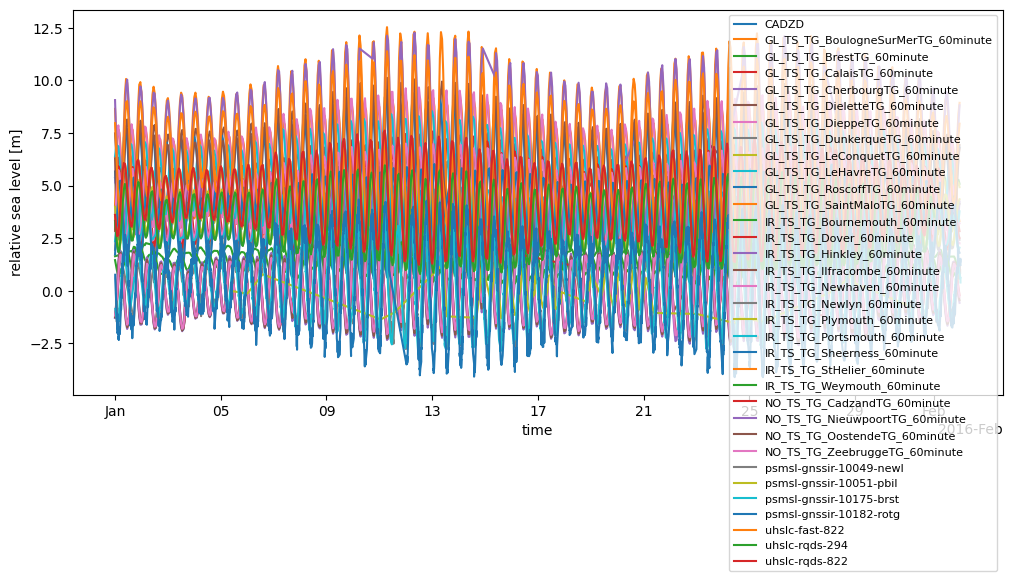

In [6]:
# plot the retrieved datasets
fig,ax = plt.subplots(figsize=(12,5))
file_list = glob.glob(os.path.join(dir_output, "*.nc"))
file_list.sort()
for file_nc in file_list:
    ds = xr.open_dataset(file_nc)
    station_name = os.path.basename(file_nc).strip(".nc")
    ds.waterlevel.plot(ax=ax, label=station_name)
    del ds
ax.legend(loc=1, fontsize=8)


creating overview for 34 files: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 


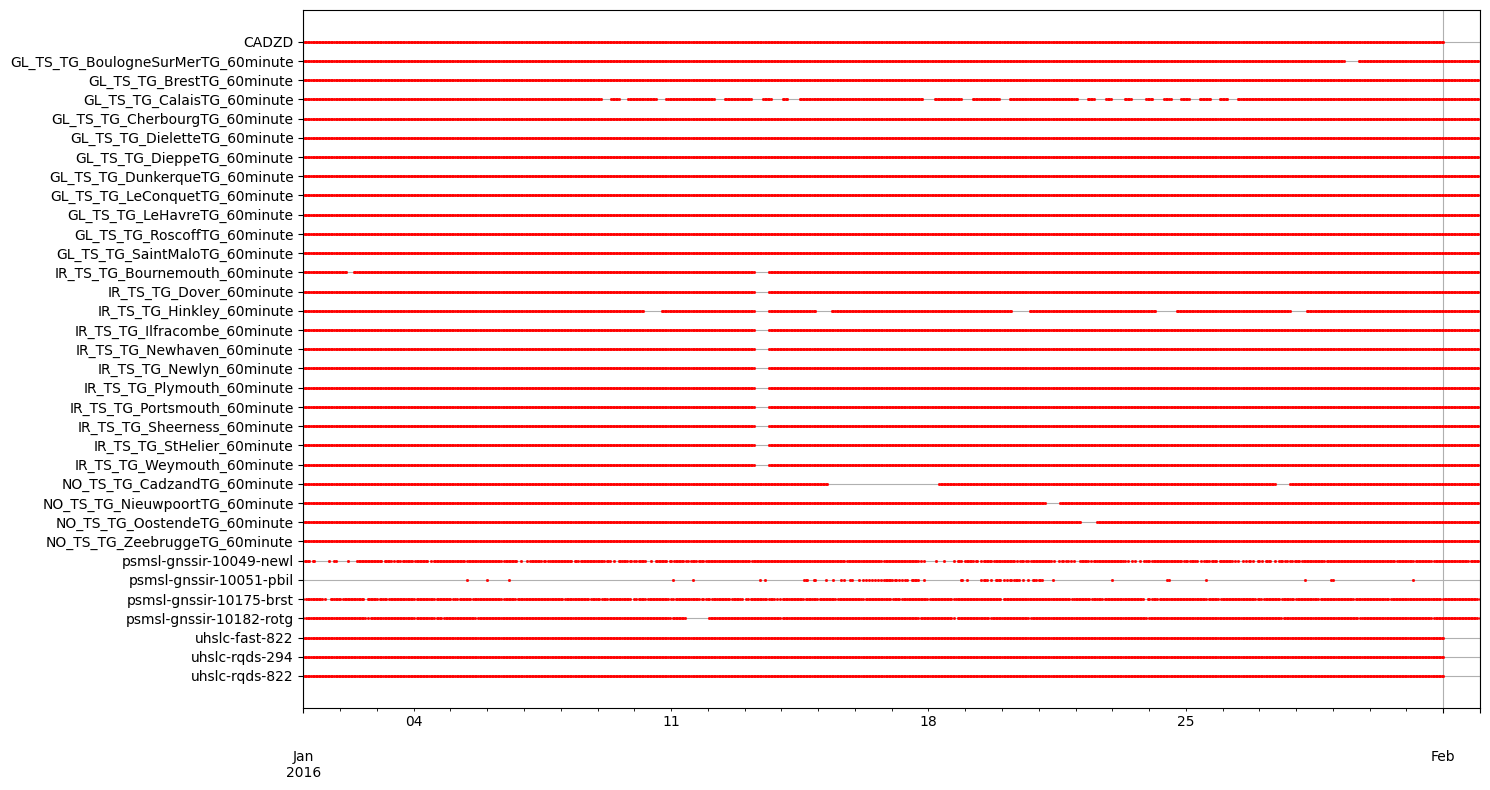

In [7]:
# create overview plot and statistics csv
dfmt.ssh_netcdf_overview(dir_output, perplot=40)
